# Fifa 18 Value Prediction
## Data Modeling

### Table of Contents

1. [Data Preparation](#preparation)
    1. [Load the data](#load)
    2. [Prepare the data](#prepare)
    3. [Feature selection](#feature_selection)
    4. [Train and test split](#split)
2. [Data Modeling](#modeling)
    1. [Linear Regression Model](#linear_regression)
    2. [Polynomial Regression Model](#polynomial_regression)
    3. [Lasso Regression](#lasso_regression)
    4. [Linear Regression Model (TensorFlow)](#linear_regression_tf)
3. [Model Evaluation](#evaluation)
    1. [RMSE](#rmse)
    2. [Cross Validation](#cross_validation)
    3. [Learning Curves](#learning_curves)
4. [Export the results](#export)

In [1]:
# Imports
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from IPython.display import display, Markdown as md
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures

# Config
# %matplotlib notebook
%matplotlib inline
pd.options.display.max_columns = None

## Data Preparation <a id="preparation"></a>
### Load the data <a id="load"></a>
Loads *.csv* file (without *outliers* in *Value* and *Wage*) into *pandas DataFrame*

In [2]:
df_model = pd.read_csv("data/processed/CompleteDataset_cleaned_iqr.csv", sep=";")

### Prepare the data <a id="prepare"></a>
To simplify the model, let's exclude the goalkeepers (*GK*), so we don't have to deal with *null* values. Also, deletes rows where *Value* is 0.

In [3]:
exclude_GK = df_model["Preferred Position_GK"] == 0
exclude_value_0 = df_model["Value"] > 0
df_model = df_model[exclude_GK & exclude_value_0]


df_model.reset_index(inplace=True)
names = df_model["Name"].copy()
df_model = df_model.drop("Name", axis="columns")

In [4]:
# Define 'target' and 'features'
target = "Value"
features = df_model.columns.values
features = features[features != target]

X = df_model.loc[:, features].values
y = df_model.loc[:, [target]].values

print("X type: {0} - X shape: {1}".format(type(X), X.shape))
print("y type: {0} - y shape: {1}".format(type(y), y.shape))

X type: <class 'numpy.ndarray'> - X shape: (12992, 82)
y type: <class 'numpy.ndarray'> - y shape: (12992, 1)


### Feature selection<a id="feature_selection"></a>
Let's apply a *feature selection* method in order to reduce the number of attributes in the dataset. Fewer attributes is desirable because it reduces the complexity of the model, and a simpler model is simpler to understand and explain. Also, this reduces the training time.

In [5]:
# Here we prioritize reducing training time instead of model accuracy
feature_selector = SelectKBest(f_regression, k=20) # Select the best 'k' features based on 'f_regression'

X = feature_selector.fit_transform(X, y.ravel())
features_selected = feature_selector.get_support() # Boolean array

display(md("*X* shape: {0}".format(X.shape)))

features = features[features_selected] # Update 'features'

c:\users\matias\miniconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
c:\users\matias\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
c:\users\matias\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
c:\users\matias\miniconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


*X* shape: (12992, 20)

### Train and test split <a id="split"></a>
Splits the dataset into a *train set* (80%) and *test set* (20%)

In [6]:
X_train, X_test, y_train, y_test, index_train, index_test = train_test_split(X, y, names.index.values, test_size=0.2, random_state=42)

display(md("*X_train* shape: {0} - *X_test* shape: {1}".format(X_train.shape, X_test.shape)))
display(md("*y_train* shape: {0} - *y_test* shape: {1}".format(y_train.shape, y_test.shape)))

*X_train* shape: (10393, 20) - *X_test* shape: (2599, 20)

*y_train* shape: (10393, 1) - *y_test* shape: (2599, 1)

## Data Modeling <a id="modeling"></a>
### Linear Regression Model <a id="linear_regression"></a>
Creates and fits the model

In [7]:
lin_reg = LinearRegression(fit_intercept=True, normalize=False)
lin_reg.fit(X_train, y_train);

Let's visualize the highest *Linear Regression coefficients*

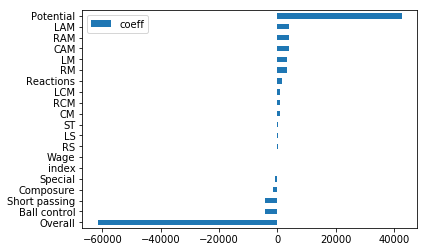

In [8]:
# Create new DataFrame with the coefficients per each feature
coeff_df = pd.DataFrame(data=lin_reg.coef_[0], index=features, columns=["coeff"])
coeff_df.sort_values(by="coeff", ascending=False, inplace=True) # Sort 'coeff_df' in descending order

coeff_df.iloc[0:20].sort_values(by="coeff").plot.barh();

In [9]:
display("Independent term: {0}".format(lin_reg.intercept_[0]))

# If all the features values are 0, the predictions must be equal to the independent term. Let's check this!
X_zeros = np.zeros(shape=(1, X_train.shape[1]))
display("Prediction result made with an array of zeros: {}".format(lin_reg.predict(X_zeros)))

'Independent term: 3534568.8697356945'

'Prediction result made with an array of zeros: [[3534568.86973569]]'

Saves the prediction in *predictions_lin_reg*

In [10]:
predictions_lin_reg = lin_reg.predict(X_test)

### Polynomial Regression Model <a id="polynomial_regression"></a>
A simple way to use a linear model to fit nonlinear data is to add powers of each feature as new features, and then train a linear model on this extended set of features.

In [11]:
d = 2 # Polynomial degree
poly_features = PolynomialFeatures(degree=d, include_bias=False)

# Add the square of each feature and the combinations of features up to 2 degree
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)

The number of features created by *PolynomialFeatures* can be calculated with the following equation:

\begin{align}
\frac{(n + d)!}{d!n!}\
\end{align}

In [12]:
n = X.shape[1]
poly_features_count = int(math.factorial(n + d) / (math.factorial(d) * math.factorial(n))) - 1

display(md("*X_train_poly* should now have {0} features".format(poly_features_count)))

display(md("*X* shape: {0}".format(X.shape)))
display(md("*X_train_poly* shape: {0}".format(X_train_poly.shape)))
display(md("*X_test_poly* shape: {0}".format(X_test_poly.shape)))

*X_train_poly* should now have 230 features

*X* shape: (12992, 20)

*X_train_poly* shape: (10393, 230)

*X_test_poly* shape: (2599, 230)

In [13]:
poly_reg = LinearRegression()
poly_reg.fit(X_train_poly, y_train)
predictions_poly = poly_reg.predict(X_test_poly)

### Lasso Regression<a id="lasso_regression"></a>
Is a regularized version of *Linear Regression*. It adds a regularization term to the cost function. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible.

In [14]:
lasso_reg = Lasso(alpha=2, max_iter=2000)
lasso_reg.fit(X_train_poly, y_train)
predictions_lasso = lasso_reg.predict(X_test_poly)

c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


### Linear Regression Model (TensorFlow)<a id="linear_regression_tf"></a>
Let´s make a *Linear Regression* with *TensorFlow* library.

In [15]:
tf.reset_default_graph()

n_epochs = 10000
learning_rate = 0.00000001

X_train_tf = np.c_[np.ones((X_train.shape[0], 1)), X_train]

# 'y_pred_tf' = 'X_tf' * 'theta'
X_tf = tf.constant(X_train_tf, dtype=tf.float32, name="X")
theta = tf.Variable(tf.random_uniform([n + 1, 1], -1.0, 1.0, seed=42), name="theta")
y_pred_tf = tf.matmul(X_tf, theta, name="predictions")

# Calculates the error ('y_pred_tf' - 'y_tf')
y_tf = tf.constant(y_train, dtype=tf.float32, name="y")
error = y_pred_tf - y_tf
mse = tf.reduce_mean(tf.square(error), name="mse")

In [16]:
# Minimizes the MSE with Gradient Descent
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(mse)

In [17]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        if epoch % 1000 == 0:
            print("Epoch {0} - RMSE: {1}".format(epoch, np.sqrt(mse.eval())))
        sess.run(training_op)
    
    best_theta = theta.eval()

Epoch 0 - RMSE: 1316996.375
Epoch 1000 - RMSE: 591579.25
Epoch 2000 - RMSE: 591455.0625
Epoch 3000 - RMSE: 591332.5
Epoch 4000 - RMSE: 591210.3125
Epoch 5000 - RMSE: 591088.6875
Epoch 6000 - RMSE: 590967.375
Epoch 7000 - RMSE: 590846.5625
Epoch 8000 - RMSE: 590726.1875
Epoch 9000 - RMSE: 590606.375


In [18]:
X_test_tf = np.c_[np.ones((X_test.shape[0], 1)), X_test]

# Makes the predictions: 'X_test_tf' * 'best_theta'
predictions_lin_reg_tf = np.matmul(X_test_tf, best_theta)

## Model Evaluation <a id="evaluation"></a>
### RMSE <a id="rmse"></a>

In [19]:
lin_mse = mean_squared_error(predictions_lin_reg, y_test)
poly_mse = mean_squared_error(predictions_poly, y_test)
lasso_mse = mean_squared_error(predictions_lasso, y_test)
lin_reg_tf_mse = mean_squared_error(predictions_lin_reg_tf, y_test)
lin_rmse = np.sqrt(lin_mse)
poly_rmse = np.sqrt(poly_mse)
lasso_rmse = np.sqrt(lasso_mse)
lin_reg_tf_rmse = np.sqrt(lin_reg_tf_mse)

display(md("**Linear Regression - Root Mean Squared Error: €{0:,}**".format(int(lin_rmse))))
display(md("**Polynomial Regression - Root Mean Squared Error: €{0:,}**".format(int(poly_rmse))))
display(md("**Lasso Regression - Root Mean Squared Error: €{0:,}**".format(int(lasso_rmse))))
display(md("**Linear Regression (TensorFlow) - Root Mean Squared Error: €{0:,}**".format(int(lin_reg_tf_rmse))))

**Linear Regression - Root Mean Squared Error: €544,665**

**Polynomial Regression - Root Mean Squared Error: €344,593**

**Lasso Regression - Root Mean Squared Error: €341,774**

**Linear Regression (TensorFlow) - Root Mean Squared Error: €606,079**

### Cross Validation <a id="cross_validation"></a>
Let's apply *K Fold Cross Validation* to get a more accurate estimate of model prediction performance.

In [20]:
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=5)
lin_rmse_scores = np.sqrt(-lin_scores)

poly_scores = cross_val_score(poly_reg, X_train_poly, y_train, scoring="neg_mean_squared_error", cv=5)
poly_rmse_scores = np.sqrt(-poly_scores)

lasso_scores = cross_val_score(lasso_reg, X_train_poly, y_train, scoring="neg_mean_squared_error", cv=5)
lasso_rmse_scores = np.sqrt(-lasso_scores)

display(md("**Linear Regression Model**"))
display(md("Scores: {0}".format(lin_rmse_scores)))
display(md("Mean: {0:,.2f}".format(lin_rmse_scores.mean())))
display(md("Standard deviation: {0:,.2f}".format(lin_rmse_scores.std())))

display(md("**Polynomial Regression Model**"))
display(md("Scores: {0}".format(poly_rmse_scores)))
display(md("Mean: {0:,.2f}".format(poly_rmse_scores.mean())))
display(md("Standard deviation: {0:,.2f}".format(poly_rmse_scores.std())))

display(md("**Lasso Regression Model**"))
display(md("Scores: {0}".format(lasso_rmse_scores)))
display(md("Mean: {0:,.2f}".format(lasso_rmse_scores.mean())))
display(md("Standard deviation: {0:,.2f}".format(lasso_rmse_scores.std())))

c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want t

**Linear Regression Model**

Scores: [524788.1827583  542831.26003838 545928.23357984 536251.44334574
 525476.48703859]

Mean: 535,055.12

Standard deviation: 8,686.59

**Polynomial Regression Model**

Scores: [307639.1492486  312617.55711013 325094.04118742 332221.95703265
 320110.10931071]

Mean: 319,536.56

Standard deviation: 8,735.61

**Lasso Regression Model**

Scores: [309985.89338894 321832.07757284 328508.87239496 339038.89235165
 324534.74017048]

Mean: 324,780.10

Standard deviation: 9,432.25

### Learning Curves <a id="learning_curves"></a>
These are plots of the model's performance on the training set and the validation set as a function of the training set size. These plots help us to analyze if the models are *underfitting* or *overfitting* the data.

In [21]:
def plot_learning_curves(model, X, y, step=500):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    x_values = range(1, len(X_train), step)
    for m in x_values:
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(x_values, np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(x_values, np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("Training set size", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)
    plt.yscale("log")  

The **Linear Regression Model** is underfitting the data. The curves reached a plateau, and adding more training examples don't help (*low variance*). We have to use a more complex model (*Polynomial Regression Model*) or come up with better features.

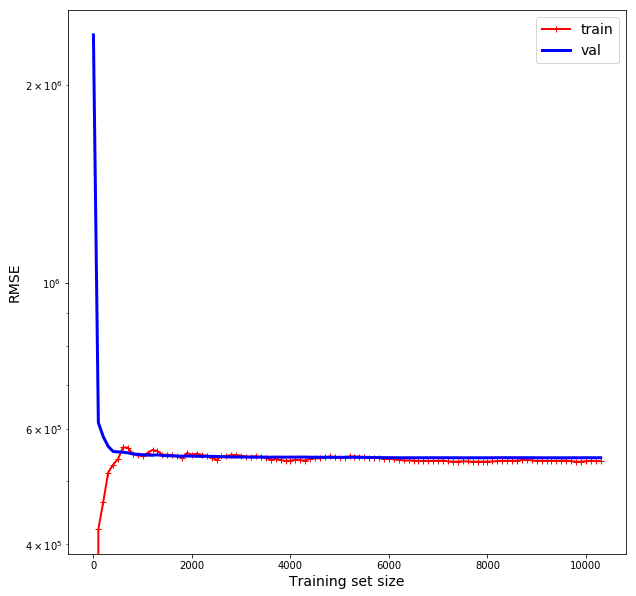

In [22]:
# # Plots the learning curves for the Linear Regression Model
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
plot_learning_curves(lin_reg, X, y, step=100)
plt.show()

The **Polynomial Regression Model** fits better, but it has more *variance* (the gap between the curves is bigger) than the **Linear Regression Model**

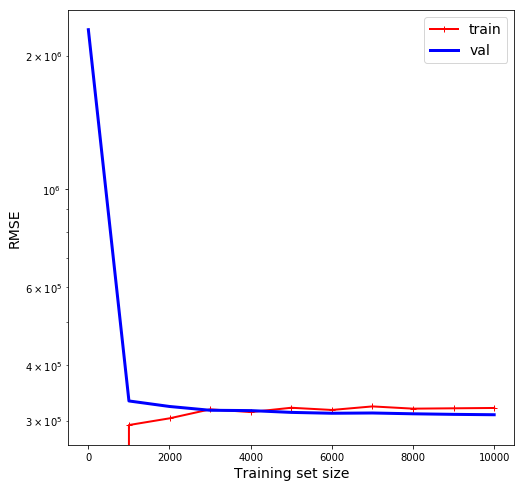

In [23]:
# Plots the learning curves for the Polynomial Regression Model
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
X_poly = np.append(X_train_poly, X_test_poly, axis=0)
y_poly = np.append(y_train, y_test, axis=0)
plot_learning_curves(poly_reg, X_poly, y_poly, step=1000)
plt.show()

**Lasso Regression** prevents overfitting, so the gap between the curves should be smaller

c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\matias\miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want t

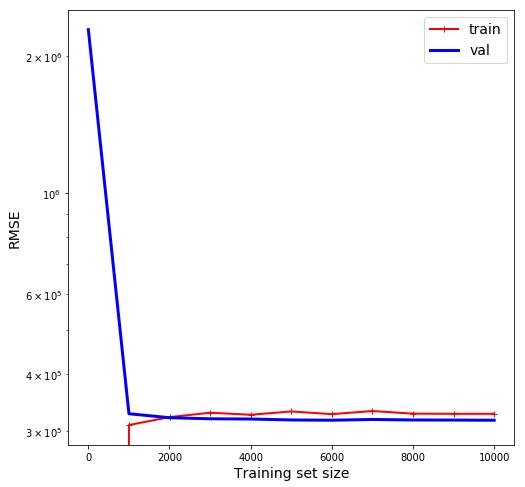

In [24]:
# Plots the learning curves for the Lasso Regression Model
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
X_poly = np.append(X_train_poly, X_test_poly, axis=0)
y_poly = np.append(y_train, y_test, axis=0)
plot_learning_curves(lasso_reg, X_poly, y_poly, step=1000)
plt.show()

## Results <a id="export"></a>
### Append the results<a id="append_results"></a>

In [25]:
predictions_series = pd.Series(data=predictions_lin_reg.flatten().tolist(), name="Prediction Linear Regression")
predictions_poly_series = pd.Series(data=predictions_poly.flatten().tolist(), name="Prediction Polynomial Regression")
predictions_lasso_series = pd.Series(data=predictions_lasso.flatten().tolist(), name="Prediction Lasso Regression")
predictions_lin_reg_tf_series = pd.Series(data=predictions_lin_reg_tf.flatten().tolist(), 
                                          name="Prediction Lasso Regression (TF)")

X_test_df = pd.DataFrame(data=X_test, columns=features)
X_test_df["Name"] = names[index_test].values

y_test_series = pd.Series(data=y_test.flatten().tolist(), name="Value")
results_df = pd.concat([X_test_df, y_test_series, predictions_series, predictions_poly_series, 
                        predictions_lasso_series, predictions_lin_reg_tf_series], axis=1, ignore_index=False)

display(results_df.head())

,index,Overall,Potential,Wage,Special,Ball control,Composure,Reactions,Short passing,CAM,CM,LAM,LCM,LM,LS,RAM,RCM,RM,RS,ST,Name,Value,Prediction Linear Regression,Prediction Polynomial Regression,Prediction Lasso Regression,Prediction Lasso Regression (TF)
0,13260.0,57.0,69.0,2000.0,1578.0,61.0,44.0,55.0,68.0,56.0,56.0,56.0,56.0,54.0,50.0,56.0,56.0,54.0,50.0,50.0,R. Öktem,180000.0,-1.969699e+04,271991.295713,343486.273921,9.535288e+04
1,4347.0,68.0,68.0,15000.0,1715.0,72.0,65.0,65.0,58.0,62.0,55.0,62.0,55.0,63.0,67.0,62.0,55.0,63.0,67.0,67.0,Cris Laranjeiros,575000.0,1.513157e+06,952245.242732,918703.708163,1.736628e+06
2,6745.0,66.0,73.0,2000.0,1728.0,71.0,63.0,69.0,68.0,63.0,65.0,63.0,65.0,64.0,59.0,63.0,65.0,64.0,59.0,59.0,Pité,750000.0,1.004555e+06,895447.922096,838018.393555,9.428139e+05
3,5601.0,67.0,67.0,8000.0,1633.0,62.0,65.0,64.0,58.0,59.0,53.0,59.0,53.0,57.0,66.0,59.0,53.0,57.0,66.0,66.0,M. Grüttner,675000.0,1.090061e+06,648653.406745,609441.224388,1.232308e+06
4,12192.0,59.0,70.0,2000.0,1515.0,60.0,50.0,53.0,63.0,58.0,54.0,58.0,54.0,58.0,55.0,58.0,54.0,58.0,55.0,55.0,I. Colman,270000.0,2.234241e+05,278528.878132,313275.037690,1.599928e+05


### Overrated and undervalued players

In [26]:
results_df["difference"] = results_df["Prediction Lasso Regression"] - results_df["Value"]

display(md("Most **Overrated** players"))
display(results_df.sort_values(by="difference", ascending=True).head())

display(md("Most **Undervalued** players"))
display(results_df.sort_values(by="difference", ascending=False).head())

Most **Overrated** players

,index,Overall,Potential,Wage,Special,Ball control,Composure,Reactions,Short passing,CAM,CM,LAM,LCM,LM,LS,RAM,RCM,RM,RS,ST,Name,Value,Prediction Linear Regression,Prediction Polynomial Regression,Prediction Lasso Regression,Prediction Lasso Regression (TF),difference
340,211.0,74.0,74.0,13000.0,1663.0,64.0,72.0,67.0,67.0,54.0,59.0,54.0,59.0,55.0,52.0,54.0,59.0,55.0,52.0,52.0,Ewerton,4600000.0,2.088396e+06,3.156702e+06,3.023911e+06,2.051366e+06,-1.576089e+06
529,541.0,73.0,74.0,12000.0,1884.0,66.0,62.0,75.0,69.0,70.0,65.0,70.0,65.0,70.0,72.0,70.0,65.0,70.0,72.0,72.0,Quique,4700000.0,2.253126e+06,3.458369e+06,3.327441e+06,2.176612e+06,-1.372559e+06
1448,479.0,73.0,74.0,9000.0,1826.0,70.0,70.0,70.0,67.0,71.0,66.0,71.0,66.0,72.0,67.0,71.0,66.0,72.0,67.0,67.0,M. Barrios,4700000.0,2.215914e+06,3.446497e+06,3.340126e+06,2.007175e+06,-1.359874e+06
741,169.0,74.0,74.0,5000.0,2004.0,70.0,69.0,82.0,76.0,71.0,72.0,71.0,72.0,68.0,72.0,71.0,72.0,68.0,72.0,72.0,N. Fuenzas,4400000.0,1.980807e+06,3.274694e+06,3.042270e+06,2.028181e+06,-1.357730e+06
1058,160.0,74.0,74.0,5000.0,1816.0,72.0,64.0,72.0,68.0,58.0,63.0,58.0,63.0,61.0,61.0,58.0,63.0,61.0,61.0,61.0,E. Evaldes,4400000.0,1.877988e+06,3.323736e+06,3.077849e+06,1.857606e+06,-1.322151e+06


Most **Undervalued** players

,index,Overall,Potential,Wage,Special,Ball control,Composure,Reactions,Short passing,CAM,CM,LAM,LCM,LM,LS,RAM,RCM,RM,RS,ST,Name,Value,Prediction Linear Regression,Prediction Polynomial Regression,Prediction Lasso Regression,Prediction Lasso Regression (TF),difference
22,18.0,78.0,78.0,18000.0,1834.0,73.0,75.0,73.0,75.0,64.0,69.0,64.0,69.0,61.0,59.0,64.0,69.0,61.0,59.0,59.0,Hilton,700000.0,2.211197e+06,4.320623e+06,4.501300e+06,2.440008e+06,3.801300e+06
2504,595.0,73.0,73.0,26000.0,1972.0,70.0,78.0,70.0,72.0,68.0,68.0,68.0,68.0,68.0,67.0,68.0,68.0,68.0,67.0,67.0,O. Kuzmin,450000.0,2.426731e+06,2.850082e+06,2.859941e+06,2.833683e+06,2.409941e+06
1680,278.0,74.0,74.0,8000.0,1614.0,61.0,67.0,67.0,59.0,49.0,54.0,49.0,54.0,49.0,51.0,49.0,54.0,49.0,51.0,51.0,Ricardo,750000.0,1.908063e+06,3.093593e+06,2.910522e+06,1.787515e+06,2.160522e+06
2211,35.0,77.0,77.0,16000.0,1784.0,69.0,69.0,73.0,77.0,57.0,62.0,57.0,62.0,61.0,58.0,57.0,62.0,61.0,58.0,58.0,David García,2100000.0,2.116003e+06,4.683055e+06,4.208220e+06,2.307048e+06,2.108220e+06
366,192.0,74.0,74.0,3000.0,1902.0,69.0,84.0,75.0,72.0,67.0,70.0,67.0,70.0,64.0,64.0,67.0,70.0,64.0,64.0,64.0,A. Pérez,750000.0,1.884249e+06,2.779662e+06,2.623628e+06,1.849943e+06,1.873628e+06


### Export the results

In [27]:
results_df.to_csv("data/output/predictions.csv", sep=";", index=False, float_format="%.0f")